# Expediting Car Evaluations with ML 
###  Data Science and Advanced Analytics
###  Machine Learning 1st Phase Delivery

**Group 18**  
- Diogo Tibério         20250341
- José Montez           20250351
- Henrique Figueiredo   20250433
- Sebastião Jerónimo    20240660


<a id="index"></a>
## Index

1. [Introduction to the Project](#introduction)  
   - 1.1. [Project Overview & Objectives](#project_overview)
   - 1.2. [Dataset Import data exploration](#data_exploration)  
      - 1.2.1. [Import Libraries](#import_libraries)
      - 1.2.3. [Dataset Import and Initial Checks](#dataset_import)
         - 1.2.3.1 [Verify Dataset Integrity](#check_imports)
      - 1.2.4. [Dataset Metadata Description](#metadata_description)
      - 1.2.5. [Descriptive Statistics](#descriptive_statistics)
      - 1.2.6. [Exploratory Data Analysis (EDA)](#eda)
         - 1.2.6.1. [Univariate Analysis](#univariate_analysis)
         - 1.2.6.2. [Multivariate Relationships](#multivariate_analysis)  

2. [Data Preparation](#data_preparation)  
   - 2.1. [Handling Missing Values](#handling_missing_values)  
   - 2.2. [Outlier Detection and Treatment](#outliers)  
   - 2.3. [Categorical Variable Encoding](#categorical_encoding)  
   - 2.4. [Feature Engineering](#feature_engineering)  
   - 2.5. [Data Scaling and Normalization](#data_scaling)  

3. [Feature Selection](#feature_selection)  
   - 3.1. [Feature Selection Strategy](#selection_strategy)  
   - 3.2. [Implementation and Results](#selection_implementation)  
   - 3.3. [Final Feature Set Justification](#feature_justification)  

4. [Model Building and Evaluation](#model_building)  
   - 4.1. [Problem Type Identification](#problem_type)  
   - 4.2. [Algorithm Selection](#algorithm_selection)  
   - 4.3. [Model Assessment Strategy](#assessment_strategy)  
   - 4.4. [Model Training and Prediction](#model_training)  
   - 4.5. [Performance Metrics and Interpretation](#performance_metrics)  


<hr>
<a class="anchor" id="introduction"></a>

# 1. Introduction to the Project

Cars 4 You is an online car resale company that sells cars from multiple different brands.

The company's goal is to replace the evaluation process by creating a predictive model capable of evaluating the price of a car based on the user’s input without needing the car to be taken to a mechanic.

This project aims to build this model.

<hr>
<a class="anchor" id="project_overview"></a>

## 1.1. Project Overview & Objectives

1. Regression Benchmarking: we aim to develop a regression model that accurately predicts car prices (price). 

2. Model Optimization: During our selection of best (or set of best) model(s) we will explore ways to improve their performance.

3. Additional Insights we aim to explore:

   a.Analyze and discuss the importance of the features for the different values of the target variable and how they contribute towards the prediction.

   b.Ablation Study: Measure the contribution of each element of the pipeline.

   c.Create an analytics interface that returns a prediction when new input data is provided.

   d.Test whether the best performance is achieved using a general model (trained using data from all brands/models, etc...) or using brand, model, fuel type, etc...-specific models.

   e.Determine whether training a Deep Learning network from scratch is moreeffective than fine-tuning a pre-trained model. 

<hr>
<a class="anchor" id="data_exploration"></a>

## 1.2. Dataset Import data exploration

1. Import the dataset and explore the data (3 points):
   
   a. Check data contents, provide descriptive statistics and check for inconsistencies in the data.
   
   b. Explore data visually and extract relevant insights. Explain your rationale and findings. Do not forget to analyse multivariate relationships.

<hr>
<a class="anchor" id="import_libraries"></a>

### 1.2.1. Import Libraries

In [319]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from rapidfuzz import process, fuzz
import re
import numpy as np
from typing import Sequence, Mapping, Optional

# Encoding and Scaling
from sklearn.preprocessing import OneHotEncoder, RobustScaler, TargetEncoder, MinMaxScaler
import category_encoders as ce

#wrapper methods and embedded methods 
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import RFECV, RFE

# Cross validation and splitting the data
from sklearn.model_selection import KFold, cross_val_score, train_test_split

# Linear regression models
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso

#Evaluation metrics
from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_error

<hr>
<a class="anchor" id="dataset_import"></a>

### 1.2.2 Dataset Import and Initial Checks

Import train, test and samples submission data

In [320]:
"""
    Loads a CSV datasets into pandas DataFrames.
    Handles missing file paths and encoding issues gracefully.
"""
try:
    train_car_data_original = pd.read_csv('data//train.csv')
    test_car_data_original = pd.read_csv('data//test.csv')
    sample_submission_car_data_original = pd.read_csv('data/sample_submission.csv')
# For when the file directory is not found
except FileNotFoundError as f:
    print(f"File not found: {f.filename}")
# For general errors
except Exception as e:
    print(f"An error occurred: {e}")

# Makes a preventive copy so it does not modify the original reference
train_car_data = train_car_data_original.copy()
test_car_data = test_car_data_original.copy()
sample_submission_car_data = sample_submission_car_data_original.copy()


<hr>
<a class="anchor" id="check_imports"></a>

### 1.3. Verify Dataset Integrity

Check to see if the train, test and submission datasets were correctly imported

In [321]:
train_car_data.head()

,carID,Brand,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
0,69512,VW,Golf,2016.0,22290,Semi-Auto,28421.0,Petrol,NaN,11.417268,2.0,63.0,4.000000,0.0
1,53000,Toyota,Yaris,2019.0,13790,Manual,4589.0,Petrol,145.0,47.900000,1.5,50.0,1.000000,0.0
2,6366,Audi,Q2,2019.0,24990,Semi-Auto,3624.0,Petrol,145.0,40.900000,1.5,56.0,4.000000,0.0
3,29021,Ford,FIESTA,2018.0,12500,anual,9102.0,Petrol,145.0,65.700000,1.0,50.0,-2.340306,0.0
4,10062,BMW,2 Series,2019.0,22995,Manual,1000.0,Petrol,145.0,42.800000,1.5,97.0,3.000000,0.0


In [322]:
test_car_data.head()

,carID,Brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
0,89856,Hyundai,I30,2022.878006,Automatic,30700.000000,petrol,205.0,41.5,1.6,61.0,3.0,0.0
1,106581,VW,Tiguan,2017.000000,Semi-Auto,-48190.655673,Petrol,150.0,38.2,2.0,60.0,2.0,0.0
2,80886,BMW,2 Series,2016.000000,Automatic,36792.000000,Petrol,125.0,51.4,1.5,94.0,2.0,0.0
3,100174,Opel,Grandland X,2019.000000,Manual,5533.000000,Petrol,145.0,44.1,1.2,77.0,1.0,0.0
4,81376,BMW,1 Series,2019.000000,Semi-Auto,9058.000000,Diesel,150.0,51.4,2.0,45.0,4.0,0.0


In [323]:
sample_submission_car_data.head()

,carID,price
0,89856,851000
1,106581,514000
2,80886,323000
3,100174,921000
4,81376,620000


In [324]:
print("Train dataset:")
print(train_car_data.shape)

print("Test dataset:")
print(test_car_data.shape)

print("Samples submission dataset:")
print(sample_submission_car_data.shape)

Train dataset:
(75973, 14)
Test dataset:
(32567, 13)
Samples submission dataset:
(32567, 2)


<hr>
<a class="anchor" id="metadata_description"></a>

### 1.4 Dataset Metadata Description

| Feature | Description |
|---------|-------------|
| carID | An attribute that contains an identifier for each car |
| Brand | The car's main brand (e.g. Ford, Toyota) |
| model | The car model |
| year | The year of Registration of the Car |
| mileage | The total reported distance travelled by the car (in miles) |
| tax | The amount of road tax (in £) that, in 2020, was applicable to the car in question |
| fuelType | Type of Fuel used by the car (Diesel, Petrol, Hybrid, Electric) |
| mpg | Average Miles per Gallon |
| engineSize | Size of Engine in liters (Cubic Decimeters) |
| paintQuality% | The mechanic's assessment of the cars' overall paint quality and hull integrity (filled by the mechanic during evaluation) |
| previousOwners | Number of previous registered owners of the vehicle |
| hasDamage | Boolean marker filled by the seller at the time of registration stating whether the car is damaged or not |
| price | The car's price when purchased by Cars 4 You (in £) |

In [325]:
train_car_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75973 entries, 0 to 75972
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   carID           75973 non-null  int64  
 1   Brand           74452 non-null  object 
 2   model           74456 non-null  object 
 3   year            74482 non-null  float64
 4   price           75973 non-null  int64  
 5   transmission    74451 non-null  object 
 6   mileage         74510 non-null  float64
 7   fuelType        74462 non-null  object 
 8   tax             68069 non-null  float64
 9   mpg             68047 non-null  float64
 10  engineSize      74457 non-null  float64
 11  paintQuality%   74449 non-null  float64
 12  previousOwners  74423 non-null  float64
 13  hasDamage       74425 non-null  float64
dtypes: float64(8), int64(2), object(4)
memory usage: 8.1+ MB


**Dataset Info:** 75,973 entries × 14 columns

Just by looking at this stats we can see some potential issues and improvements:

- **Missing Data**: `tax` and `mpg` features have significantly fewer entries and require missing data handling

- **Discarded Feature**: `carID` column will be removed as it's an identifier

**Data Types:**
- 8 features: `float64`
- 2 features: `int64` 
- 4 features: `object` (categorical variables)

`hasDamage` represents just a boolean it can be an int64 (1 for true 0 for false)

`year` represents just an year it can also be an int64 since it will not be a decimal value

**Categorical Variables (4):**
- Cannot be used directly by models we will have to adress this problem
- Chi-squared test can measure correlation between categorical features
- Visualize relationships with heatmap

**Numerical Variables:**
- Analyze correlations using Pearson/Spearman correlation methods
- Visualize with correlation matrix heatmap

In [326]:
test_car_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32567 entries, 0 to 32566
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   carID           32567 non-null  int64  
 1   Brand           31918 non-null  object 
 2   model           31917 non-null  object 
 3   year            31914 non-null  float64
 4   transmission    31944 non-null  object 
 5   mileage         31878 non-null  float64
 6   fuelType        31911 non-null  object 
 7   tax             29259 non-null  float64
 8   mpg             29279 non-null  float64
 9   engineSize      31939 non-null  float64
 10  paintQuality%   31942 non-null  float64
 11  previousOwners  31970 non-null  float64
 12  hasDamage       31970 non-null  float64
dtypes: float64(8), int64(1), object(4)
memory usage: 3.2+ MB


**Dataset Info:** 32567 entries × 13 columns  
It has less one collumn as the dataset before because it is the dataset that we use for training it is not labeled with price.

We see the same preprocessing issues as above.


In [327]:
#Lets check the statistics of the train data with the test data.

<hr>
<a class="anchor" id="descriptive_statistics"></a>

### 1.5 Descriptive Statistics

We can use describe to obtain the most relevant descriptive statistics

In [328]:
train_car_data.describe().T

,count,mean,std,min,25%,50%,75%,max
carID,75973.0,37986.000000,21931.660338,0.000000,18993.00,37986.0,56979.0,75972.000000
year,74482.0,2017.096611,2.208704,1970.000000,2016.00,2017.0,2019.0,2024.121759
price,75973.0,16881.889553,9736.926322,450.000000,10200.00,14699.0,20950.0,159999.000000
mileage,74510.0,23004.184088,22129.788366,-58540.574478,7423.25,17300.0,32427.5,323000.000000
tax,68069.0,120.329078,65.521176,-91.121630,125.00,145.0,145.0,580.000000
mpg,68047.0,55.152666,16.497837,-43.421768,46.30,54.3,62.8,470.800000
engineSize,74457.0,1.660136,0.573462,-0.103493,1.20,1.6,2.0,6.600000
paintQuality%,74449.0,64.590667,21.021065,1.638913,47.00,65.0,82.0,125.594308
previousOwners,74423.0,1.994580,1.472981,-2.345650,1.00,2.0,3.0,6.258371
hasDamage,74425.0,0.000000,0.000000,0.000000,0.00,0.0,0.0,0.000000


In [329]:
test_car_data.describe().T

,count,mean,std,min,25%,50%,75%,max
carID,32567.0,92256.000000,9401.427445,75973.000000,84114.50,92256.0,100397.5,108539.000000
year,31914.0,2017.102299,2.207969,1991.000000,2016.00,2017.0,2019.0,2024.121759
mileage,31878.0,22952.658921,22132.758713,-58540.574478,7298.25,17225.5,32500.0,279000.000000
tax,29259.0,120.569239,65.560570,-91.121630,125.00,145.0,145.0,580.000000
mpg,29279.0,55.210728,17.644635,-43.421768,46.30,54.3,62.8,470.800000
engineSize,31939.0,1.665377,0.574467,-0.103493,1.20,1.6,2.0,6.600000
paintQuality%,31942.0,64.446667,21.142188,1.638913,47.00,65.0,82.0,125.594308
previousOwners,31970.0,2.006118,1.472310,-2.345650,1.00,2.0,3.0,6.258371
hasDamage,31970.0,0.000000,0.000000,0.000000,0.00,0.0,0.0,0.000000


In [330]:
train_car_data.drop('hasDamage', axis = 1, inplace = True)
test_car_data.drop('hasDamage', axis = 1, inplace = True)

In [331]:
'hasDamage' in test_car_data.columns or 'hasDamage' in train_car_data.columns 

False


Variables that are constant in a **dataset** are not useful for prediction because they do not provide any information that can help differentiate between different possible outcomes

In our case its hasDamage which has variance is equal to 0, we will drop this feature both in the test and train datasets.

We identified the following issues with the descriptive statistics

**Constant Feature:**
- `hasDamage`: All values are 0, indicating a univariate feature with no predictive power.

**Outliers Detected:**
- `price`: Maximum value (159,999) significantly exceeds 75th percentile (20,950)
- `mileage`: Maximum value (323,000) far above 75th percentile (32,427.5)

**Invalid Values:**
- `mileage`: Negative minimum value (-58,540.57) - impossible for distance
- `year`: Decimal maximum year value - invalid year format
- `tax`, `mpg`, `previousOwners`: Negative minimum values - impossible for these metrics

<hr>
<a class="anchor" id="descriptive_statistics"></a>

## 1.6 EDA


<hr>
<a class="anchor" id="descriptive_statistics"></a>

### 1.6.1 Univariate Analysis

Variables that are constant in a dataset are not useful for prediction because they do not provide any information that can help differentiate between different possible outcomes

In our case its hasDamage which has variance is equal to 0, we will drop this feature both in the test and train datasets.

To check the distribution of the data lets make some histograms.


<hr>
<a class="anchor" id="descriptive_statistics"></a>

### 1.6.2. Multivariate Relationships

Here we are going to explore the relations between features.

But first lets explore each individual feature.


From the histograms of numerical features we can see that price, mileage, tax, mpg and engineSize are skeweed to the right, whereas year is skeweed to the left.

In all of this cases we are going to use the median as the statictics to fill the missing data in these columns, because the median is less sensitive to outliers that the mean.

Regarding the other 3 features, for paintQuality% and previousOwners we can use the mean, because they seem to follow a more normal distribution.


<hr>
<a class="anchor" id="eda"></a>

# 2 Data Preparation

For easier comprehension and mroe readbale code the traiin and test datsets will be jooined. Precuations ........ Data Leakage 

In [332]:
train_car_data["train"] = True
test_car_data["train"] = False

df = pd.concat([train_car_data, test_car_data], ignore_index=True)
df

,carID,Brand,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,train
0,69512,VW,Golf,2016.0,22290.0,Semi-Auto,28421.00000,Petrol,NaN,11.417268,2.0,63.0,4.000000,True
1,53000,Toyota,Yaris,2019.0,13790.0,Manual,4589.00000,Petrol,145.0,47.900000,1.5,50.0,1.000000,True
2,6366,Audi,Q2,2019.0,24990.0,Semi-Auto,3624.00000,Petrol,145.0,40.900000,1.5,56.0,4.000000,True
3,29021,Ford,FIESTA,2018.0,12500.0,anual,9102.00000,Petrol,145.0,65.700000,1.0,50.0,-2.340306,True
4,10062,BMW,2 Series,2019.0,22995.0,Manual,1000.00000,Petrol,145.0,42.800000,1.5,97.0,3.000000,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108535,105775,VW,Tiguan,2017.0,NaN,Manual,27575.00000,Petrol,145.0,46.300000,1.4,94.0,1.000000,False
108536,81363,BMW,X2,2020.0,NaN,Automatic,1980.00000,Petrol,145.0,34.000000,2.0,39.0,3.000000,False
108537,76833,Audi,Q5,2019.0,NaN,Semi-Auto,8297.00000,Diesel,145.0,38.200000,2.0,88.0,4.000000,False
108538,91768,Mercedes,A Class,2019.0,NaN,Manual,-50755.21023,Petrol,145.0,28.500000,1.3,81.0,1.000000,False


In [333]:
df = df.set_index("carID")

## 2.1 Ensuring consistent dtypes aligned with column description and problem specification

In [334]:
len(df)

108540

In [335]:
cols = ["mpg", "mileage", "engineSize", "previousOwners"]

(df[cols] < 0).sum()

mpg                53
mileage           539
engineSize        117
previousOwners    539
dtype: int64

In [336]:
df[cols] = df[cols].where(df[cols] >= 0, np.nan)


## 2.2 Fuzzy matching invaliid strings in categorical colummns 

In [337]:
col_c = df.columns[(df.dtypes == "object") | (df.nunique() < 20)].tolist()
col_n = df.columns.difference(col_c).tolist()

In [338]:
col_c

['Brand', 'model', 'transmission', 'fuelType', 'previousOwners', 'train']

In [339]:
col_n

['engineSize', 'mileage', 'mpg', 'paintQuality%', 'price', 'tax', 'year']

In [340]:
# First of all we will lowercase these 4 cols to ensure data consistency when comparing strings
cols_fuzzy = ["Brand", "model", "transmission", "fuelType"]

In [341]:
unique_values = df[cols_fuzzy].apply(lambda x: x.unique()).to_dict()

for col, values in unique_values.items():
    print(f"{col}:\n{values}\n")

Brand:
['VW' 'Toyota' 'Audi' 'Ford' 'BMW' 'Skoda' 'Opel' 'Mercedes' 'FOR'
 'mercedes' 'Hyundai' 'w' 'ord' 'MW' 'bmw' nan 'yundai' 'BM' 'Toyot' 'udi'
 'Ope' 'AUDI' 'V' 'opel' 'pel' 'For' 'pe' 'Mercede' 'audi' 'MERCEDES'
 'OPEL' 'koda' 'FORD' 'Hyunda' 'W' 'Aud' 'vw' 'hyundai' 'skoda' 'ford'
 'TOYOTA' 'ercedes' 'oyota' 'toyota' 'SKODA' 'Skod' 'HYUNDAI' 'kod' 'v'
 'for' 'SKOD' 'aud' 'KODA' 'PEL' 'yunda' 'or' 'UDI' 'OYOTA' 'HYUNDA' 'mw'
 'OPE' 'mercede' 'ERCEDES' 'ercede' 'TOYOT' 'MERCEDE' 'ORD' 'ud' 'ope'
 'AUD' 'hyunda' 'skod' 'toyot' 'M' 'YUNDAI' 'oyot' 'bm']

model:
[' Golf' ' Yaris' ' Q2' ' FIESTA' ' 2 Series' '3 Series' ' A3' ' Octavia'
 ' Passat' ' Focus' ' Insignia' ' A Clas' ' Q3' ' Fabia' ' A Class' ' Ka+'
 ' 3 Series' ' GLC Class' ' I30' ' C Class' ' Polo' ' E Class' ' C Clas'
 ' Q5' ' Up' ' Fiesta' ' C-HR' ' Mokka X' ' Corsa' ' Astra' ' TT'
 ' 5 Series' ' Aygo' ' 4 Series' ' SLK' ' Viva' ' T-Roc' 'Focus'
 ' EcoSport' ' Tucson' ' EcoSpor' nan ' X-CLASS' ' CL Class' ' IX20'
 ' i20

In [342]:
def normalize_string(string: str) -> str:
    string = str(string).lower().strip()
    return re.sub(r"[^a-z0-9]+", "", string) # removes spaces


def fuzzy_fix(x: object, correct_names: Sequence[str], aliases: Optional[Mapping[str, str]] = None,  cutoff: int = 80):

    # creates a dict with the normalized strings as the keys and the not normalized strings as values from the input list
    canon_map = {normalize_string(label): label for label in correct_names}
    # create a list with only the keys (normalized strings)
    choice_keys = list(canon_map.keys())

    normalized_name = normalize_string(x)

    # Normalize alias keys too; alias values should be canonical brands
    if aliases:
        alias_normalized = {normalize_string(key): value for key, value in aliases.items()}
        if normalized_name in alias_normalized:
            return alias_normalized[normalized_name]

    # if the normalized string is already the correct name return it
    if normalized_name in canon_map:
        return canon_map[normalized_name]

    # it the normalized string doesn't correct to the correct name the use fuzzy match to match the name to the correct one
    match = process.extractOne(normalized_name, choice_keys, scorer=fuzz.WRatio, score_cutoff=cutoff)
    return canon_map[match[0]] if match else np.nan # returns the match with the highest similarity score

In [343]:
brands_list = ["Volkswagen", "Toyota", "Audi", "Ford", "BMW", "Skoda", "Opel", "Mercedes", "Hyundai"]
brands_aliases = {"vw":"Volkswagen","v":"Volkswagen","merc":"Mercedes","bm":"BMW"}

In [344]:
train_fuzzy = df[df["train"] == True][cols_fuzzy]

train_fuzzy["Brand"] = train_fuzzy["Brand"].map(lambda brand: fuzzy_fix(brand, brands_list, brands_aliases, cutoff=84))
train_fuzzy["Brand"].unique()

array(['Volkswagen', 'Toyota', 'Audi', 'Ford', 'BMW', 'Skoda', 'Opel',
       'Mercedes', 'Hyundai', nan], dtype=object)

In [345]:
test_fuzzy = df[df["train"] == False][cols_fuzzy]

test_fuzzy["Brand"] = test_fuzzy["Brand"].map(lambda brand: fuzzy_fix(brand, brands_list, brands_aliases, cutoff=84))
test_fuzzy["Brand"].unique()

array(['Hyundai', 'Volkswagen', 'BMW', 'Opel', 'Ford', 'Mercedes',
       'Skoda', 'Toyota', 'Audi', nan], dtype=object)

In [346]:
transmissions_list = ["Manual","Automatic","Semi-Automatic", "Other", "Unkown"]
transmissions_alises = {"mt":"Manual","man":"Manual","auto":"Automatic","at":"Automatic","dsg":"Automatic"}

In [347]:
train_fuzzy["transmission"] = train_fuzzy["transmission"].map(lambda transmission: fuzzy_fix(transmission, transmissions_list, transmissions_alises, cutoff=82))
train_fuzzy["transmission"].unique()

array(['Semi-Automatic', 'Manual', 'Automatic', nan, 'Unkown', 'Other'],
      dtype=object)

In [348]:
test_fuzzy["transmission"] = test_fuzzy["transmission"].map(lambda transmission: fuzzy_fix(transmission, transmissions_list, transmissions_alises, cutoff=82))
test_fuzzy["transmission"].unique()

array(['Automatic', 'Semi-Automatic', 'Manual', 'Unkown', nan, 'Other'],
      dtype=object)

In [349]:
fueltype_list = ["Petrol", "Diesel", "Hybrid", "Electric", "Other"]

In [350]:
train_fuzzy["fuelType"] = train_fuzzy["fuelType"].map(lambda fueltype: fuzzy_fix(fueltype, fueltype_list, cutoff=82))
train_fuzzy["fuelType"].unique()

array(['Petrol', 'Diesel', 'Hybrid', nan, 'Other', 'Electric'],
      dtype=object)

In [351]:
test_fuzzy["fuelType"] = test_fuzzy["fuelType"].map(lambda fueltype: fuzzy_fix(fueltype, fueltype_list, cutoff=82))
test_fuzzy["fuelType"].unique()

array(['Petrol', 'Diesel', 'Hybrid', nan, 'Other', 'Electric'],
      dtype=object)

In [352]:
# Do the same for the car models columns
MODEL_BY_BRAND = {
    'Audi': ['A', 'A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'Q', 'Q2', 'Q3', 'Q5', 'Q7', 'Q8', 'RS', 'RS3', 'RS4', 'RS5', 'RS6', 'S', 'S1', 'S3', 'S4', 'S5', 'S6', 'SQ2', 'SQ5', 'TT', 'e-tron'],
    'BMW': ['1 Series', '2 Series', '3 Serie', '3 SERIES', '3 Series', '4 Series', '5 Serie', '5 Series', '7 Series', '8 Series', 'M2', 'M3', 'M4', 'M5', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'Z4', 'i3', 'i4'],
    'Ford': ['B-MAX', 'C-MAX', 'Ecosport', 'Edge', 'Fiesta', 'Focus', 'Galaxy', 'Ka', 'Kuga', 'Mondeo', 'Mustang', 'Puma', 'S-MAX', 'Tourneo', 'Transit'],
    'Hyundai': ['Accent', 'Getz', 'I1', 'I10', 'I2', 'I20', 'I3', 'I30', 'I40', 'I80', 'I800', 'IONIQ', 'Kona', 'Santa Fe', 'Tucson'],
    'Mercedes': ['A-Class', 'AMG GT', 'B-Class', 'C-Class', 'CLA', 'CLK', 'CLS', 'Citan', 'E-Class', 'GLA', 'GLB', 'GLC', 'GLE', 'GLK', 'GLS', 'M-Class', 'S-Class', 'GLC-Class', 'SL', 'SLC', 'SLK', 'Sprinter', 'V-Class', 'Vaneo', 'Viano'],
    'Opel': ['Adam', 'Astra', 'Corsa', 'Crossland', 'Grandland', 'Insignia', 'Karl', 'Meriva', 'Mokka', 'Vectra', 'Zafira'],
    'Skoda': ['Citigo', 'Enyaq', 'Fabia', 'Kamiq', 'Karoq', 'Kodiaq', 'Octavia', 'Rapid', 'Roomster', 'Scala', 'Superb', 'Yeti'],
    'Toyota': ['Auris', 'Avensis', 'Aygo', 'C-HR', 'Camry', 'Corolla', 'GT86', 'RAV4', 'Verso', 'Yaris'],
    'Volkswagen': ['Arteon', 'Beetle', 'Bora', 'Caddy', 'CC', 'Crafter', 'Eos', 'Fox', 'Golf', 'Golf Plus', 'ID.3', 'ID.4', 'Jetta', 'Lupo', 'Passat', 'Phaeton', 'Polo', 'Scirocco', 'Sharan', 'T-Cross', 'T-Roc', 'Tiguan', 'Touareg', 'Touran', 'Transporter', 'Up'],
}


def fix_car_models(raw_model_names: str, cleaned_brand_names):

    candidates = MODEL_BY_BRAND.get(cleaned_brand_names)
    
    if not candidates:
        # fallback to all models if brand unknown
        candidates = sorted({m for lst in MODEL_BY_BRAND.values() for m in lst})
    
    # token_set_ratio handles word order/extra tokens well
    return fuzzy_fix(raw_model_names, candidates, aliases=None, cutoff=86)

In [353]:
train_fuzzy["model"] = train_fuzzy.apply(lambda r: fix_car_models(r["model"], r["Brand"]), axis=1)
train_fuzzy["model"].unique()

array(['Golf', 'Yaris', 'Q2', 'Fiesta', '2 Series', '3 Series', 'A3',
       'Octavia', 'Passat', 'Focus', 'Insignia', 'A-Class', 'Q3', 'Fabia',
       'Ka', 'GLC-Class', 'I30', 'C-Class', 'Polo', 'E-Class', nan, 'Q5',
       'Up', 'C-HR', 'Mokka', 'Corsa', 'Astra', 'TT', '5 Series', 'Aygo',
       '4 Series', 'SLK', 'T-Roc', 'Ecosport', 'Tucson', 'CLA', 'I20',
       'Rapid', 'A1', 'Auris', 'Sharan', 'Adam', 'X3', 'A8', 'B-MAX',
       'A4', 'Kona', 'I10', 'S-MAX', 'X2', 'Crossland', 'Tiguan', 'A5',
       'Zafira', 'IONIQ', 'A6', 'Mondeo', 'Yeti', 'X1', 'Scala',
       'S-Class', '1 Series', 'Kamiq', 'Kuga', 'Tourneo', 'Q7', 'Arteon',
       'Santa Fe', 'Grandland', 'I800', 'RAV4', 'Touran', 'Citigo',
       'Roomster', 'Corolla', 'B-Class', 'Q', 'Kodiaq', 'V-Class', 'A',
       'Caddy', 'Superb', 'Getz', 'Beetle', 'Galaxy', 'M3', 'X4',
       '3 Serie', 'M4', 'Z4', 'X5', 'Meriva', 'RS6', 'Verso', 'Touareg',
       'C-MAX', 'Puma', 'I40', 'Karoq', 'I3', 'T-Cross', 'A7',
       'Golf 

In [354]:
test_fuzzy["model"] = test_fuzzy.apply(lambda r: fix_car_models(r["model"], r["Brand"]), axis=1)
test_fuzzy["model"].unique()

array(['I30', 'Tiguan', '2 Series', 'Grandland', '1 Series', 'Fiesta',
       'X1', 'B-Class', 'Focus', 'Superb', '5 Series', 'C-Class', 'Up',
       'Aygo', 'Golf', 'M-Class', nan, 'TT', 'Adam', 'Zafira', 'E-Class',
       '3 Series', 'A4', 'Yaris', 'Passat', 'I10', 'Mokka', 'Ecosport',
       '4 Series', 'A7', 'Corsa', 'Kuga', 'C-MAX', 'Q2', 'M4', 'A-Class',
       'RAV4', 'Fabia', 'Insignia', 'A1', 'X6', 'Meriva', 'Octavia',
       'Auris', 'CLA', 'Astra', 'V-Class', 'Polo', 'Karoq', 'Q5',
       'Tucson', 'A3', 'S-Class', 'Corolla', 'Ka', 'X3', 'I40', 'I20',
       'Kamiq', 'Crossland', 'Q3', 'Galaxy', 'X2', 'Kodiaq', 'GLC-Class',
       'Mondeo', 'Touran', 'X5', 'Verso', 'Touareg', 'T-Roc', 'Q', 'A5',
       'Scirocco', 'X7', 'B-MAX', '8 Series', 'A', 'A6', 'Santa Fe',
       'Beetle', 'X4', 'Sharan', 'Golf Plus', 'A8', 'Kona', 'Citigo',
       'Rapid', '3 Serie', 'SLK', 'Yeti', 'Q7', 'C-HR', 'M5', 'T-Cross',
       'Avensis', 'IONIQ', 'Z4', 'M2', 'M3', 'Arteon', 'Scala', 'Puma',


In [355]:
def findModel(df):
    count = 0
    # get indices where Brand is missing but model is not
    model_noBrand_index = df[df["Brand"].isna() & df["model"].notna()].index

    for index in model_noBrand_index:
        model = df.at[index, "model"]
        keys_found = [brand for brand, lst in MODEL_BY_BRAND.items() if model in lst]

        if keys_found:
            df.at[index, "Brand"] = keys_found[0]
            count += 1

    print(f"A total of {count} models without the respective brand were found and filled.")
    return df

In [356]:
train_fuzzy = findModel(train_fuzzy)

A total of 1515 models without the respective brand were found and filled.


In [357]:
test_fuzzy = findModel(test_fuzzy)

A total of 644 models without the respective brand were found and filled.


In [358]:
df.isna().sum()

Brand              2170
model              2167
year               2144
price             32567
transmission       2145
mileage            2691
fuelType           2167
tax               11212
mpg               11267
engineSize         2261
paintQuality%      2149
previousOwners     2686
train                 0
dtype: int64

In [359]:
df[cols_fuzzy] = pd.concat([train_fuzzy, test_fuzzy])
df

,Brand,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,train
carID,,,,,,,,,,,,,
69512,Volkswagen,Golf,2016.0,22290.0,Semi-Automatic,28421.0,Petrol,NaN,11.417268,2.0,63.0,4.0,True
53000,Toyota,Yaris,2019.0,13790.0,Manual,4589.0,Petrol,145.0,47.900000,1.5,50.0,1.0,True
6366,Audi,Q2,2019.0,24990.0,Semi-Automatic,3624.0,Petrol,145.0,40.900000,1.5,56.0,4.0,True
29021,Ford,Fiesta,2018.0,12500.0,Manual,9102.0,Petrol,145.0,65.700000,1.0,50.0,NaN,True
10062,BMW,2 Series,2019.0,22995.0,Manual,1000.0,Petrol,145.0,42.800000,1.5,97.0,3.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
105775,Volkswagen,Tiguan,2017.0,NaN,Manual,27575.0,Petrol,145.0,46.300000,1.4,94.0,1.0,False
81363,BMW,X2,2020.0,NaN,Automatic,1980.0,Petrol,145.0,34.000000,2.0,39.0,3.0,False
76833,Audi,Q5,2019.0,NaN,Semi-Automatic,8297.0,Diesel,145.0,38.200000,2.0,88.0,4.0,False


## 2.3. Handling Missing Values

In [360]:
df.isna().sum()

Brand                14
model              4328
year               2144
price             32567
transmission       2146
mileage            2691
fuelType           2167
tax               11212
mpg               11267
engineSize         2261
paintQuality%      2149
previousOwners     2686
train                 0
dtype: int64

In [361]:
train_df = df[df["train"] == True]

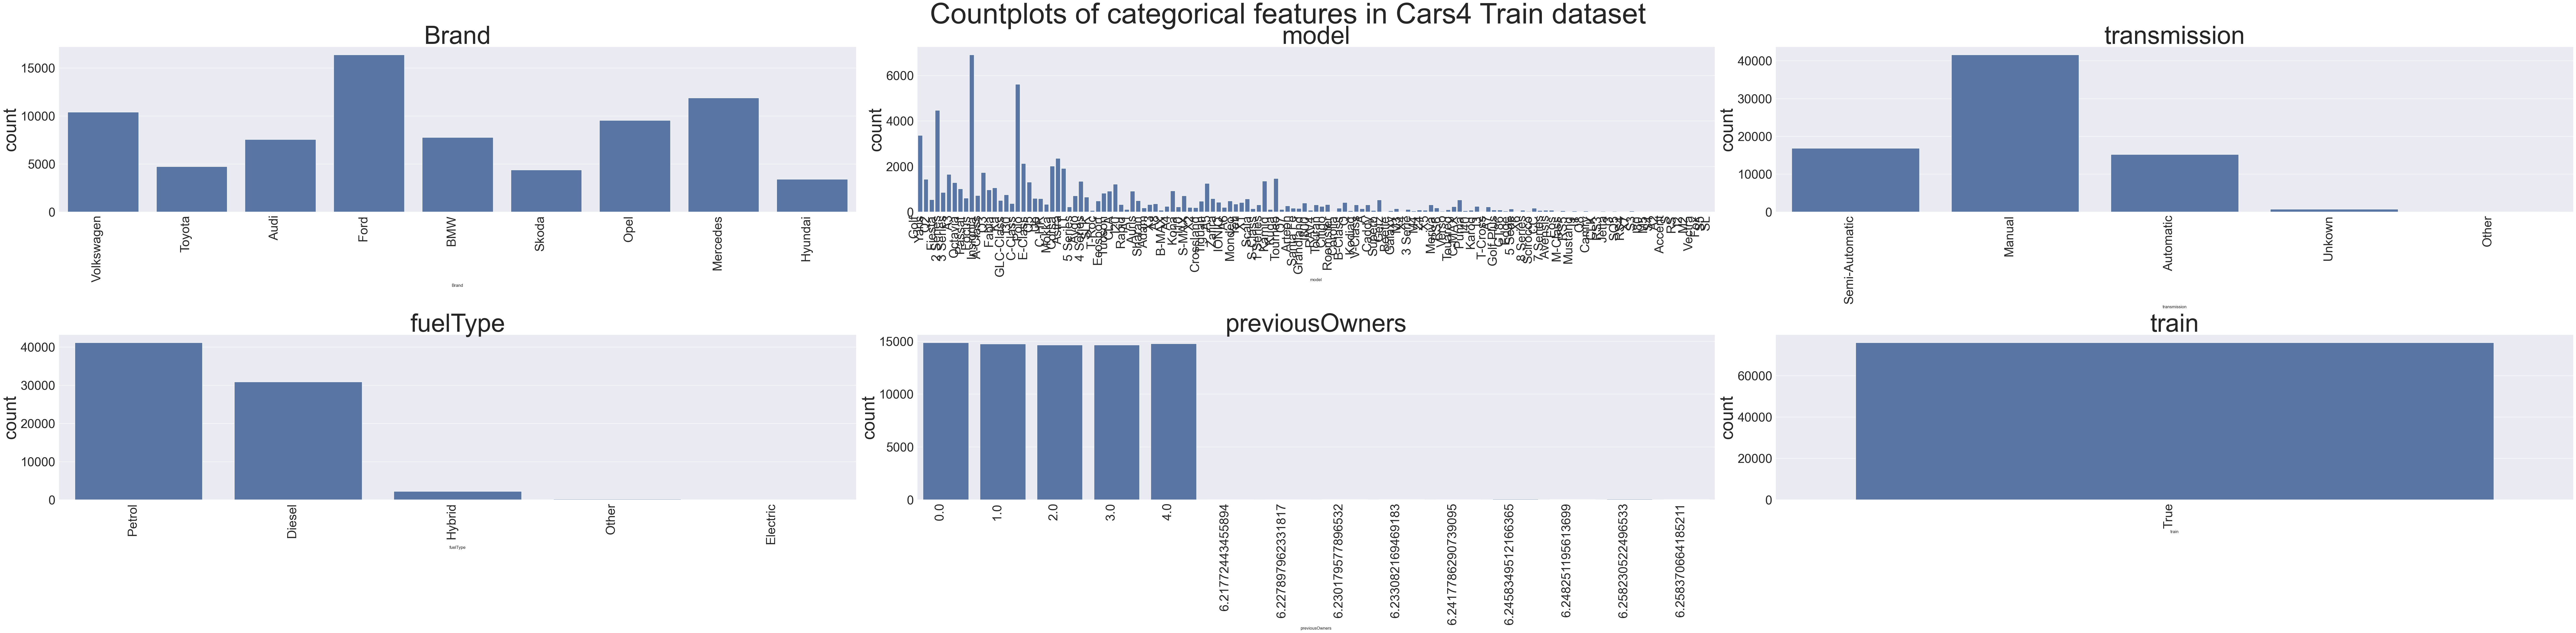

In [362]:
sns.set()

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(100, 25), tight_layout=True)

for ax, feature in zip(axes.flatten(), col_c):
    sns.countplot(data=train_df[col_c], x=feature, ax=ax)
    ax.set_title(feature, fontsize=70, pad=8)

    ax.set_ylabel("count", fontsize=50)

    ax.tick_params(axis='both', labelsize=35)

    plt.setp(ax.get_xticklabels(), rotation=90, ha='right')


fig.set_constrained_layout_pads(wspace=0.1, hspace=0.15, w_pad=0.4, h_pad=0.3)
plt.suptitle("Countplots of categorical features in Cars4 Train dataset", fontsize=80)
plt.show()

In [363]:
df.isna().sum()

Brand                14
model              4328
year               2144
price             32567
transmission       2146
mileage            2691
fuelType           2167
tax               11212
mpg               11267
engineSize         2261
paintQuality%      2149
previousOwners     2686
train                 0
dtype: int64

In [364]:
for col in col_c:
    if  col in ["Brand", "transmission", "model"]:
        df[col].fillna("Unkown", inplace=True)
    if col == "previousOwners":
        train_feature_median = train_df[col].median()
        df[col].fillna(train_feature_median, inplace=True)
    else:
        df[col].fillna("Other", inplace=True)


C:\Users\henri\AppData\Local\Temp\ipykernel_8908\652912495.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna("Unkown", inplace=True)
C:\Users\henri\AppData\Local\Temp\ipykernel_8908\652912495.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doi

In [365]:
col_n

['engineSize', 'mileage', 'mpg', 'paintQuality%', 'price', 'tax', 'year']

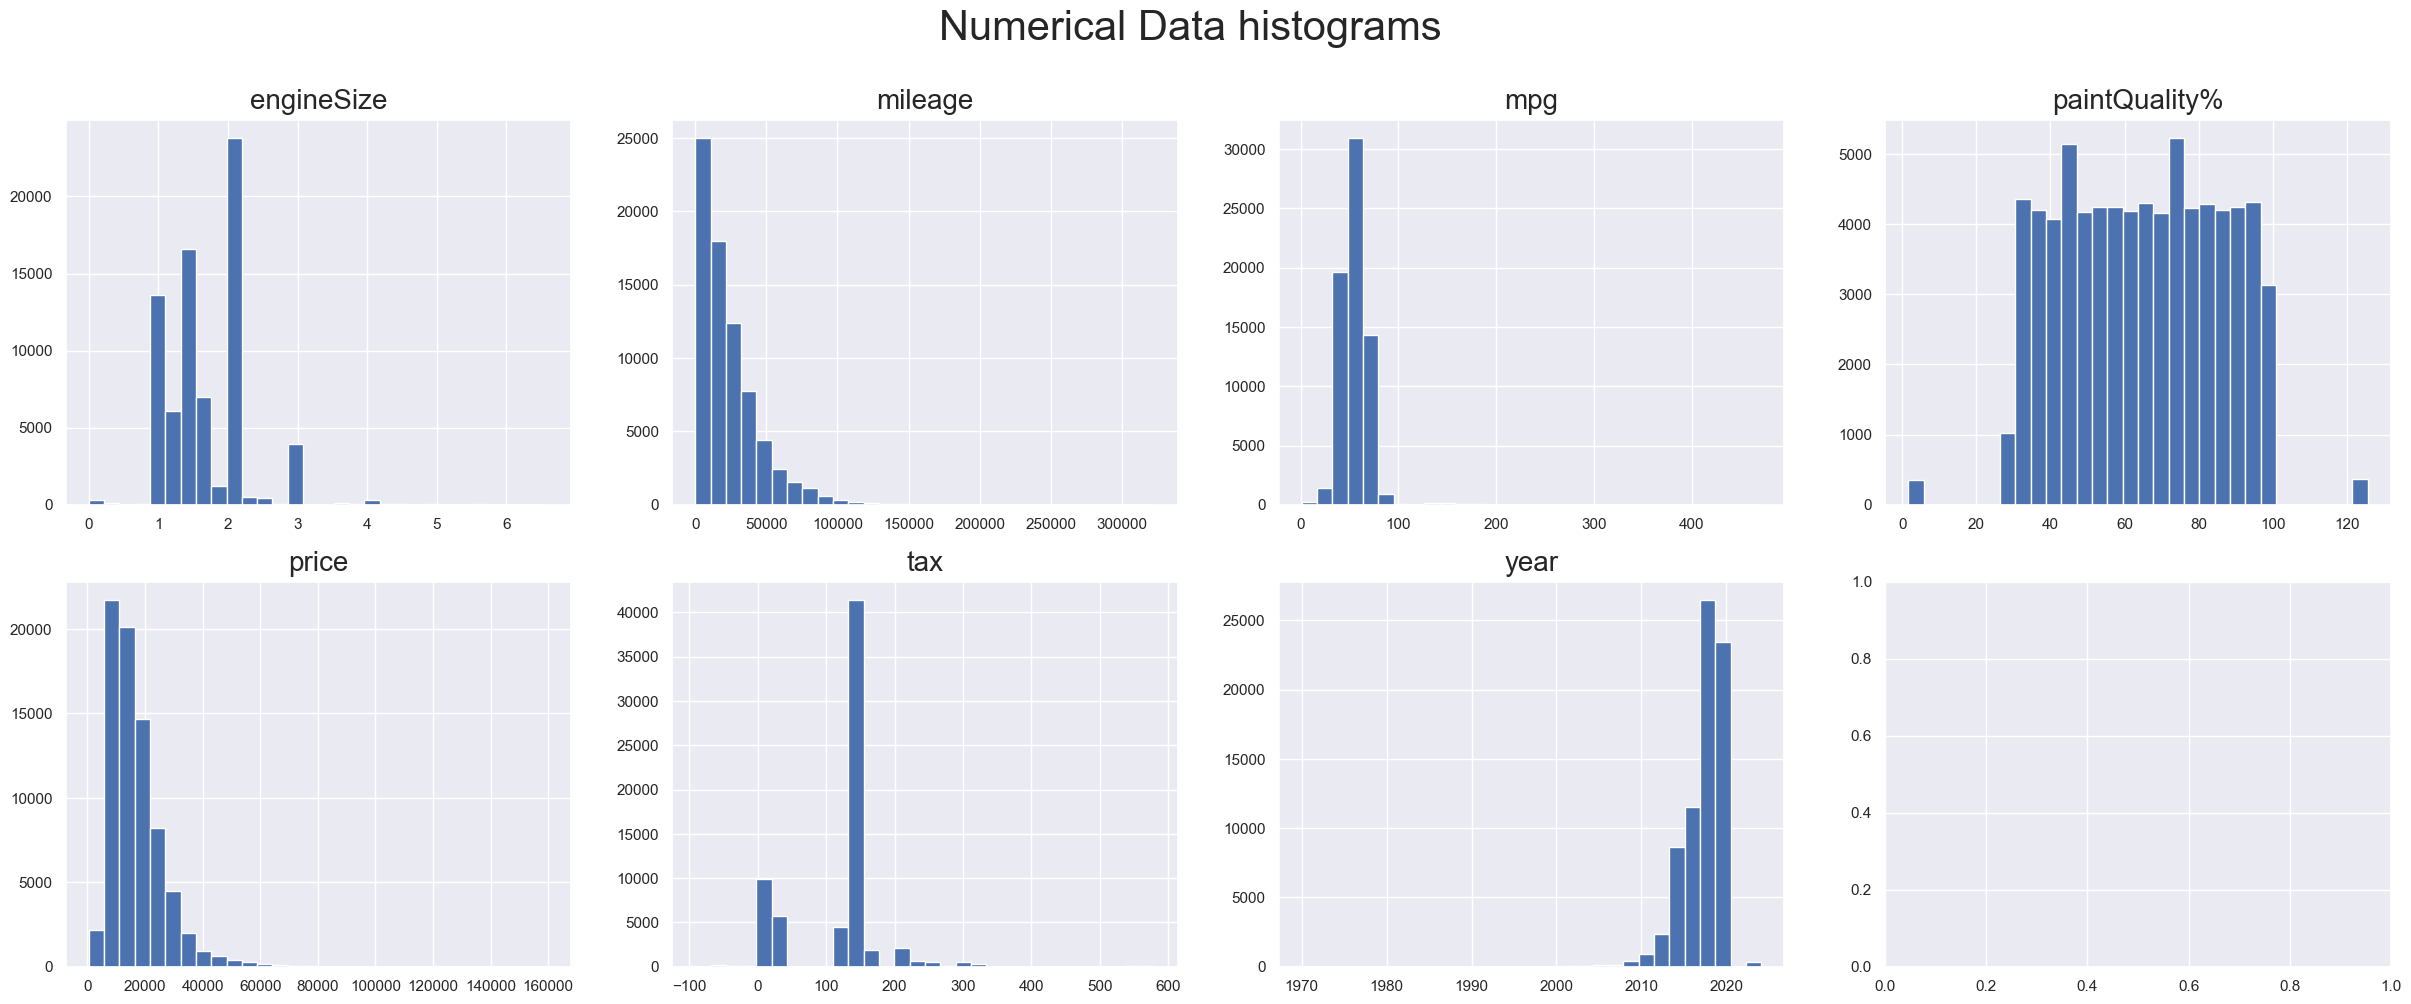

In [366]:


# Plot the numerical data (histograms)
sns.set()

# create individual axes for each one of the histograms 
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(30, 11)) 

# Iterate over each one of the elements and plot their histograms
for ax, feature in zip(axes.flatten(), train_df[col_n]):
    ax.hist(train_df[feature], bins=30)
    ax.set_title(feature, fontsize=20, pad=8)

# flatten turns a 2D array into a 1D array
# zip pairs each axis with one or more other iterables element-by-element
plt.suptitle("Numerical Data histograms", fontsize=30)

plt.show()

In [367]:
for feature in col_n:
    if feature in ["mileage", "tax",  "engineSize", "year" ]:
        train_feature_median = train_df[feature].median()
        
        # fill the missing values in train dataset with train median
        df[feature].fillna(train_feature_median, inplace=True)
    
    elif feature in ["mpg", "paintQuality%"]:
        train_feature_mean = train_df[feature].mean()

        df[feature].fillna(train_feature_mean, inplace=True)

C:\Users\henri\AppData\Local\Temp\ipykernel_8908\994581538.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[feature].fillna(train_feature_median, inplace=True)
C:\Users\henri\AppData\Local\Temp\ipykernel_8908\994581538.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For 

In [368]:
df.isna().sum()

Brand                 0
model                 0
year                  0
price             32567
transmission          0
mileage               0
fuelType              0
tax                   0
mpg                   0
engineSize            0
paintQuality%         0
previousOwners        0
train                 0
dtype: int64

<hr>
<a class="anchor" id="outliers"></a>

## 2.4. Outlier Detection and Treatment

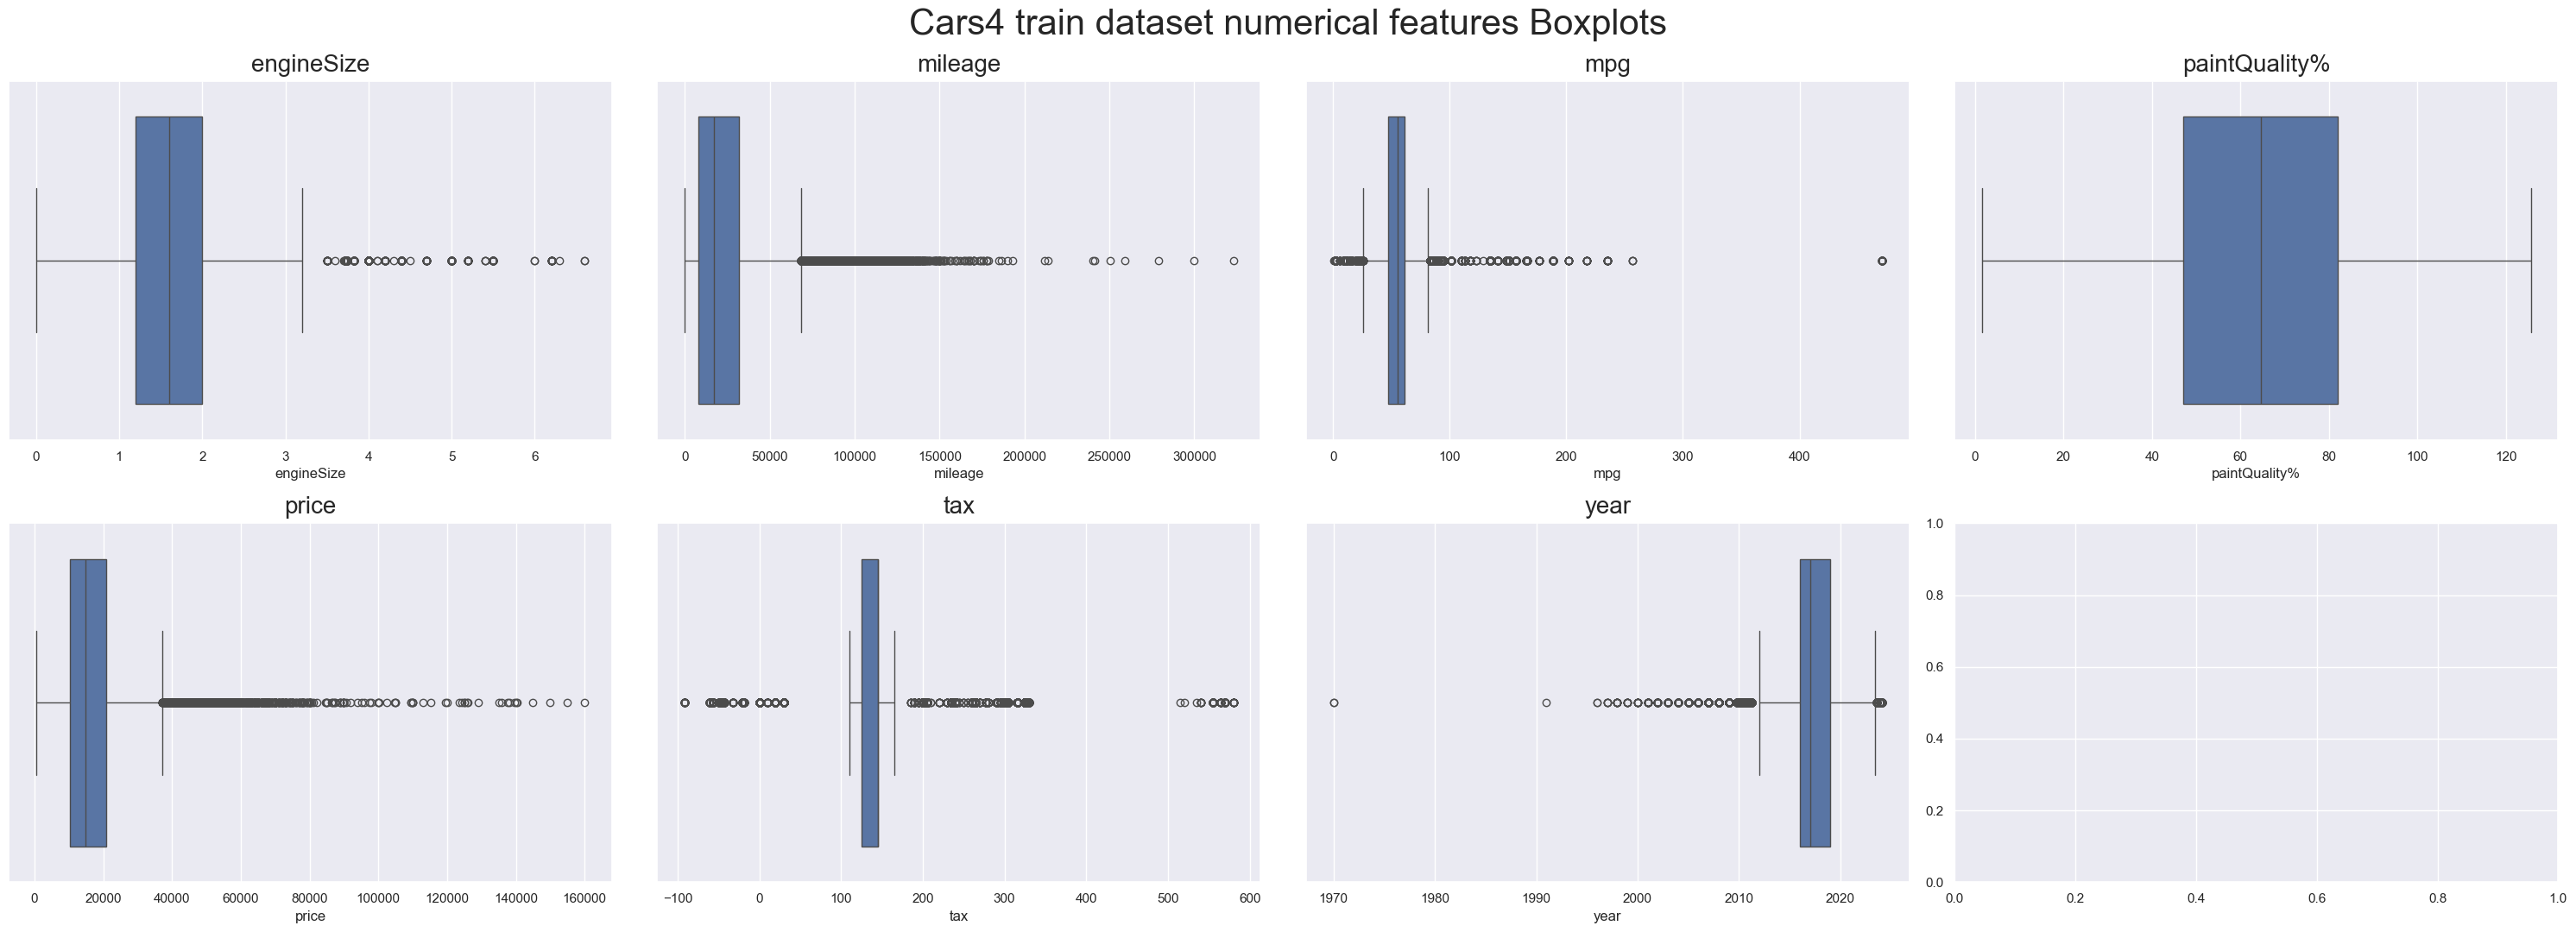

In [369]:
# boxplot train data

sns.set()

# create individual axes for each one of the boxplots 
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(30, 11), tight_layout=True) 

# Iterate over each one of the elements and plot their boxplots
for ax, feature in zip(axes.flatten(), col_n):
    sns.boxplot(x=df[feature], ax=ax)
    ax.set_title(feature, fontsize=20, pad=8)

plt.suptitle("Cars4 train dataset numerical features Boxplots", fontsize=30)    

plt.show()


In [370]:

train_cars_mask = (
    (df["train"] == True) 
    &
    (df["price"] <= 80000)
    &
    (df["mileage"].between(0, 150_000))
    &
    (df["tax"].between(0, 300))
    &
    (df["mpg"].between(0, 150))
    &
    (df["engineSize"].between(0, 5))

) 

train_no_outliers = df[train_cars_mask]
test_no_outliers = df[df["train"] == False]

# Combine them back
df_no_outliers = pd.concat([train_no_outliers, test_no_outliers], axis=0)

In [371]:
df_no_outliers.info()

<class 'pandas.core.frame.DataFrame'>
Index: 107272 entries, 69512 to 99627
Data columns (total 13 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Brand           107272 non-null  object 
 1   model           107272 non-null  object 
 2   year            107272 non-null  float64
 3   price           74705 non-null   float64
 4   transmission    107272 non-null  object 
 5   mileage         107272 non-null  float64
 6   fuelType        107272 non-null  object 
 7   tax             107272 non-null  float64
 8   mpg             107272 non-null  float64
 9   engineSize      107272 non-null  float64
 10  paintQuality%   107272 non-null  float64
 11  previousOwners  107272 non-null  float64
 12  train           107272 non-null  bool   
dtypes: bool(1), float64(8), object(4)
memory usage: 10.7+ MB


In [372]:
df_no_outliers["year"]= df_no_outliers["year"].astype("int64")
df_no_outliers["year"].unique()

array([2016, 2019, 2018, 2014, 2017, 2020, 2013, 2015, 2023, 2011, 2012,
       2007, 2005, 2004, 2010, 2024, 2009, 2006, 2000, 2008, 2003, 2022,
       2002, 1996, 1998, 1970, 1999, 2001, 1997, 1991])

<hr>
<a class="anchor" id="outliers"></a>

## 2.5. EDA

In [373]:
pearson_corr = round(df[col_n].corr(), 3)
pearson_corr

,engineSize,mileage,mpg,paintQuality%,price,tax,year
engineSize,1.000,0.101,-0.212,0.003,0.607,0.238,-0.038
mileage,0.101,1.000,0.163,-0.002,-0.412,-0.193,-0.674
mpg,-0.212,0.163,1.000,-0.002,-0.275,-0.401,-0.116
paintQuality%,0.003,-0.002,-0.002,1.000,0.000,0.002,0.002
price,0.607,-0.412,-0.275,0.000,1.000,0.285,0.471
tax,0.238,-0.193,-0.401,0.002,0.285,1.000,0.167
year,-0.038,-0.674,-0.116,0.002,0.471,0.167,1.000


<hr>
<a class="anchor" id="categorical_encoding"></a>

## 2.6. Categorical Variable Encoding

### One Hot Encoding of brand and frequency encoding of model

In [374]:
train_no_outliers = df_no_outliers[df_no_outliers["train"] == True]

In [375]:
def encode_cat_cols(df, train, ohe_cols, freq_col, method=""):


    one_hot_encoder = OneHotEncoder(drop='first', sparse_output=False)
    one_hot_encoder.fit(train[ohe_cols])

    df_ohe = one_hot_encoder.transform(df[ohe_cols])
    ohe_names = one_hot_encoder.get_feature_names_out(ohe_cols)
    df_ohe = pd.DataFrame(df_ohe, columns=ohe_names, index=df_no_outliers.index)

    # 3. Combine
    if freq_col:
        # 1. Fit encoders on train dataset
        frequency_encoder = ce.CountEncoder(cols=[freq_col], normalize=True)
        frequency_encoder.fit(train[[freq_col]])

        # 2. Transform dataset (can be train or test)
        df_freq = frequency_encoder.transform(df[[freq_col]])
        df_freq.columns = ["model_freq"] 
        df_encoded = pd.concat([df.drop(columns=[freq_col] + ohe_cols), df_freq, df_ohe], axis=1)
    
    else:
        df_encoded = pd.concat([df.drop(columns=ohe_cols), df_ohe], axis=1)

    return df_encoded
 

In [376]:
ohe_cols = ["Brand", "transmission", "fuelType"]
freq_col = "model"

df_encoded = encode_cat_cols(df_no_outliers, train_no_outliers, ohe_cols, freq_col)

In [377]:
df_encoded

,year,price,mileage,tax,mpg,engineSize,paintQuality%,previousOwners,train,model_freq,...,Brand_Unkown,Brand_Volkswagen,transmission_Manual,transmission_Other,transmission_Semi-Automatic,transmission_Unkown,fuelType_Electric,fuelType_Hybrid,fuelType_Other,fuelType_Petrol
carID,,,,,,,,,,,,,,,,,,,,,
69512,2016,22290.0,28421.0,145.0,11.417268,2.0,63.0,4.0,True,0.043946,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
53000,2019,13790.0,4589.0,145.0,47.900000,1.5,50.0,1.0,True,0.019048,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
6366,2019,24990.0,3624.0,145.0,40.900000,1.5,56.0,4.0,True,0.007108,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
29021,2018,12500.0,9102.0,145.0,65.700000,1.0,50.0,2.0,True,0.059594,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
10062,2019,22995.0,1000.0,145.0,42.800000,1.5,97.0,3.0,True,0.011378,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105775,2017,NaN,27575.0,145.0,46.300000,1.4,94.0,1.0,False,0.016599,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
81363,2020,NaN,1980.0,145.0,34.000000,2.0,39.0,3.0,False,0.002490,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
76833,2019,NaN,8297.0,145.0,38.200000,2.0,88.0,4.0,False,0.007871,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [378]:
df_encoded.reset_index(inplace=True)

In [379]:
train_df = df_encoded[df_encoded["train"]]
test_df = df_encoded[~df_encoded["train"]]

In [380]:
test_df

,carID,year,price,mileage,tax,mpg,engineSize,paintQuality%,previousOwners,train,...,Brand_Unkown,Brand_Volkswagen,transmission_Manual,transmission_Other,transmission_Semi-Automatic,transmission_Unkown,fuelType_Electric,fuelType_Hybrid,fuelType_Other,fuelType_Petrol
74705,89856,2022,NaN,30700.0,205.0,41.5,1.6,61.0,3.0,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
74706,106581,2017,NaN,17416.0,150.0,38.2,2.0,60.0,2.0,False,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
74707,80886,2016,NaN,36792.0,125.0,51.4,1.5,94.0,2.0,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
74708,100174,2019,NaN,5533.0,145.0,44.1,1.2,77.0,1.0,False,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
74709,81376,2019,NaN,9058.0,150.0,51.4,2.0,45.0,4.0,False,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107267,105775,2017,NaN,27575.0,145.0,46.3,1.4,94.0,1.0,False,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
107268,81363,2020,NaN,1980.0,145.0,34.0,2.0,39.0,3.0,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
107269,76833,2019,NaN,8297.0,145.0,38.2,2.0,88.0,4.0,False,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
107270,91768,2019,NaN,17416.0,145.0,28.5,1.3,81.0,1.0,False,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [381]:
train_df.columns

Index(['carID', 'year', 'price', 'mileage', 'tax', 'mpg', 'engineSize',
       'paintQuality%', 'previousOwners', 'train', 'model_freq', 'Brand_BMW',
       'Brand_Ford', 'Brand_Hyundai', 'Brand_Mercedes', 'Brand_Opel',
       'Brand_Skoda', 'Brand_Toyota', 'Brand_Unkown', 'Brand_Volkswagen',
       'transmission_Manual', 'transmission_Other',
       'transmission_Semi-Automatic', 'transmission_Unkown',
       'fuelType_Electric', 'fuelType_Hybrid', 'fuelType_Other',
       'fuelType_Petrol'],
      dtype='object')

In [382]:
train_df.drop(columns=['train'], inplace=True, errors='ignore')

C:\Users\henri\AppData\Local\Temp\ipykernel_8908\4231951031.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.drop(columns=['train'], inplace=True, errors='ignore')


In [383]:
train_df.columns

Index(['carID', 'year', 'price', 'mileage', 'tax', 'mpg', 'engineSize',
       'paintQuality%', 'previousOwners', 'model_freq', 'Brand_BMW',
       'Brand_Ford', 'Brand_Hyundai', 'Brand_Mercedes', 'Brand_Opel',
       'Brand_Skoda', 'Brand_Toyota', 'Brand_Unkown', 'Brand_Volkswagen',
       'transmission_Manual', 'transmission_Other',
       'transmission_Semi-Automatic', 'transmission_Unkown',
       'fuelType_Electric', 'fuelType_Hybrid', 'fuelType_Other',
       'fuelType_Petrol'],
      dtype='object')

In [384]:
test_df.drop(columns=["train", "price"], inplace=True, errors='ignore')

C:\Users\henri\AppData\Local\Temp\ipykernel_8908\1852561634.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.drop(columns=["train", "price"], inplace=True, errors='ignore')


In [385]:
feature_cols = [col for col in train_df.columns if col not in ["price", "carID"]]

X_train_1 = train_df[feature_cols]
y_train_1 = train_df["price"]

X_test_1 = test_df[feature_cols]

### Target Encoding of model and  brand

In [386]:
df_no_outliers2 = df_no_outliers.copy()
train_no_outliers2 = df_no_outliers2[df_no_outliers2["train"] == True]

In [387]:
ohe_cols = ["transmission", "fuelType"]

df_encoded_2 = encode_cat_cols(df_no_outliers2, train_no_outliers2, ohe_cols, freq_col="")
train_2 = df_encoded_2[df_encoded_2["train"] == True]

In [388]:
y_train_2 = train_2["price"]
X_train_2 = train_2[[col for col in train_2.columns if col != "price"]]

In [389]:
X_train2, X_val2, y_train2, y_val2 = train_test_split(
    X_train_2, 
    y_train_2,
    test_size=0.2)

In [390]:
import category_encoders as ce

def target_encode(X_train, y_train, X_test, cols, smoothing=1.0):

    # Initialize the encoder
    encoder = ce.TargetEncoder(cols=cols, smoothing=smoothing)
    
    # Fit on training data and transform
    X_train_enc = encoder.fit_transform(X_train, y_train)
    
    # Transform validation/test data
    X_test_enc = encoder.transform(X_test)
    
    return X_train_enc, X_test_enc



In [391]:
X_train2 = X_train2.reset_index(drop=True)
y_train2 = y_train2.reset_index(drop=True)

In [392]:
cols = ["Brand", "model"]
X_train2_enc, X_val2_enc = target_encode(X_train2, y_train2, X_val2, cols)

In [393]:
X_train2_enc

,Brand,model,year,mileage,tax,mpg,engineSize,paintQuality%,previousOwners,train,transmission_Manual,transmission_Other,transmission_Semi-Automatic,transmission_Unkown,fuelType_Electric,fuelType_Hybrid,fuelType_Other,fuelType_Petrol
0,24190.927864,25454.021134,2019,8797.0,135.0,134.500000,2.0,64.000000,1.0,True,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,16899.751733,17921.086486,2008,148297.0,200.0,46.300000,2.0,46.000000,4.0,True,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,12572.392649,17668.340278,2015,24421.0,160.0,43.500000,1.5,88.000000,4.0,True,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,24190.927864,31111.388401,2018,13436.0,145.0,50.400000,1.6,30.000000,2.0,True,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,14084.448476,18625.545894,2016,40622.0,20.0,68.900000,1.6,90.000000,2.0,True,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59759,24190.927864,23684.464134,2019,1500.0,145.0,55.204844,1.5,94.000000,2.0,True,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
59760,22419.423320,27540.094203,2018,9854.0,145.0,56.500000,2.0,56.000000,1.0,True,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
59761,16899.751733,16739.877605,2018,28668.0,150.0,61.400000,1.6,64.590667,4.0,True,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
59762,22419.423320,19729.418196,2015,27649.0,260.0,36.700000,3.0,86.000000,3.0,True,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


<hr>
<a class="anchor" id="feature_engineering"></a>

## 2.4. Feature Engineering

In [394]:
pearson_corr = round(df[col_n].corr(), 3)
pearson_corr

,engineSize,mileage,mpg,paintQuality%,price,tax,year
engineSize,1.000,0.101,-0.212,0.003,0.607,0.238,-0.038
mileage,0.101,1.000,0.163,-0.002,-0.412,-0.193,-0.674
mpg,-0.212,0.163,1.000,-0.002,-0.275,-0.401,-0.116
paintQuality%,0.003,-0.002,-0.002,1.000,0.000,0.002,0.002
price,0.607,-0.412,-0.275,0.000,1.000,0.285,0.471
tax,0.238,-0.193,-0.401,0.002,0.285,1.000,0.167
year,-0.038,-0.674,-0.116,0.002,0.471,0.167,1.000


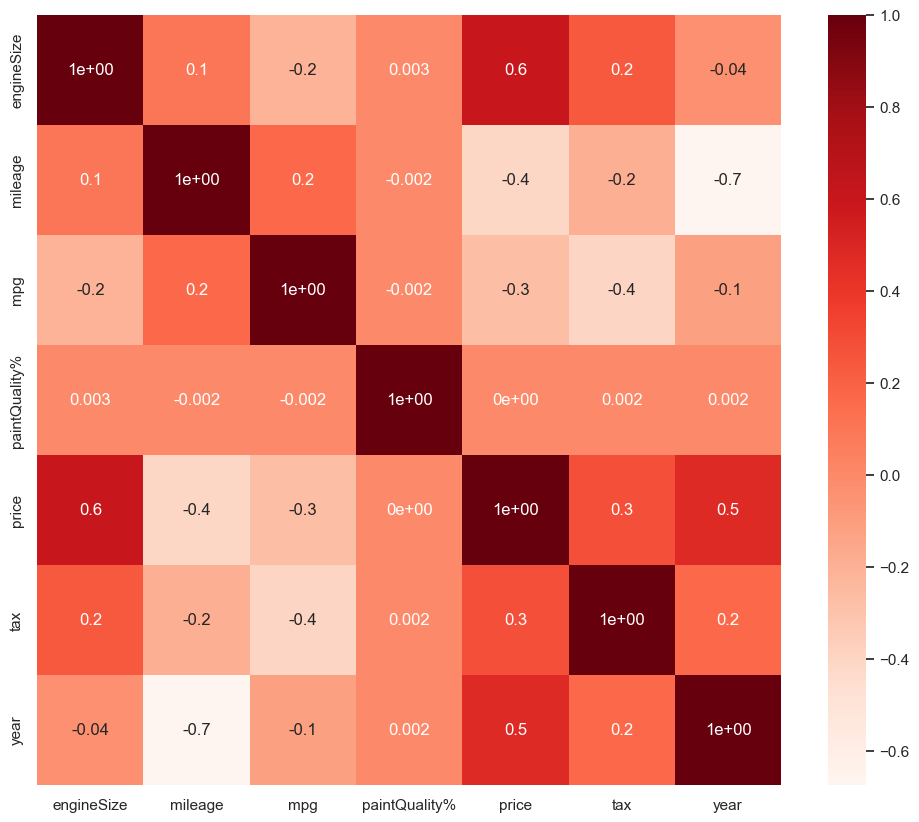

In [395]:
plt.figure(figsize=(12,10))
sns.heatmap(data = pearson_corr, annot = True, cmap = plt.cm.Reds, fmt='.1')
plt.show()

In [396]:
spearman_corr = round(df[col_n].corr(method="spearman"), 3)
spearman_corr

,engineSize,mileage,mpg,paintQuality%,price,tax,year
engineSize,1.000,0.099,-0.179,0.002,0.558,0.143,-0.039
mileage,0.099,1.000,0.307,-0.002,-0.513,-0.240,-0.771
mpg,-0.179,0.307,1.000,0.002,-0.367,-0.533,-0.295
paintQuality%,0.002,-0.002,0.002,1.000,0.003,-0.000,0.003
price,0.558,-0.513,-0.367,0.003,1.000,0.298,0.589
tax,0.143,-0.240,-0.533,-0.000,0.298,1.000,0.298
year,-0.039,-0.771,-0.295,0.003,0.589,0.298,1.000


<Axes: >

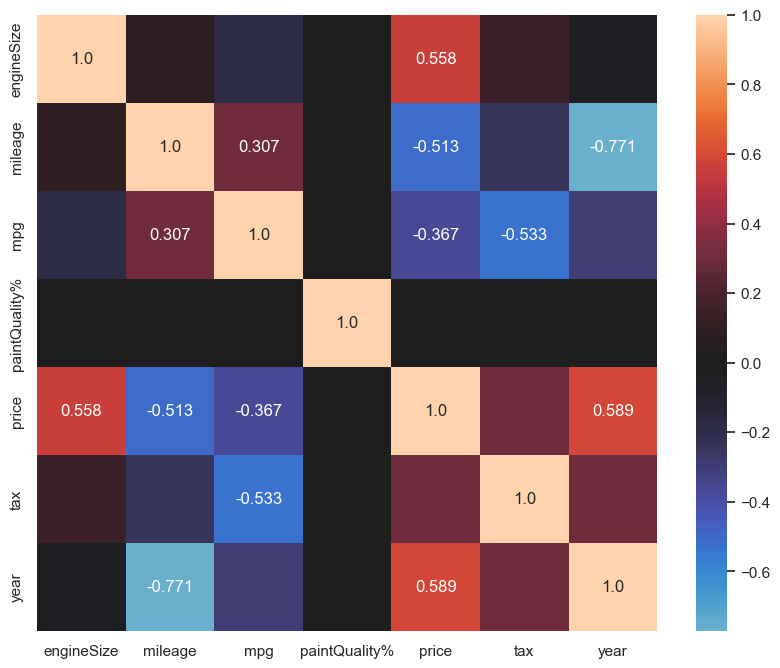

In [397]:


mask_annot = np.absolute(spearman_corr.values) >= 0.3
annot = np.where(mask_annot, spearman_corr.values, np.full(spearman_corr.shape,"")) 

fig = plt.figure(figsize=(10, 8))

sns.heatmap(data=spearman_corr, annot=annot, fmt="", center=0)



<hr>
<a class="anchor" id="data_scaling"></a>

## 2.5. Data Scaling and Normalization

In [398]:
scaler = MinMaxScaler(feature_range=(0, 1))

def scale_data(X_train, X_test, method="MinMax"):


    #fit and transform the training and only transform the test data
    train_car_enc_scaled = scaler.fit_transform(X_train)
    test_car_enc_scaled = scaler.transform(X_test)

    X_train_enc_scaled = pd.DataFrame(train_car_enc_scaled, columns=X_train.columns, index=X_train.index) 
    X_test_enc_scaled = pd.DataFrame(test_car_enc_scaled, columns=X_test.columns, index=X_test.index) 

    return X_train_enc_scaled, X_test_enc_scaled

In [399]:
X_train2_enc

,Brand,model,year,mileage,tax,mpg,engineSize,paintQuality%,previousOwners,train,transmission_Manual,transmission_Other,transmission_Semi-Automatic,transmission_Unkown,fuelType_Electric,fuelType_Hybrid,fuelType_Other,fuelType_Petrol
0,24190.927864,25454.021134,2019,8797.0,135.0,134.500000,2.0,64.000000,1.0,True,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,16899.751733,17921.086486,2008,148297.0,200.0,46.300000,2.0,46.000000,4.0,True,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,12572.392649,17668.340278,2015,24421.0,160.0,43.500000,1.5,88.000000,4.0,True,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,24190.927864,31111.388401,2018,13436.0,145.0,50.400000,1.6,30.000000,2.0,True,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,14084.448476,18625.545894,2016,40622.0,20.0,68.900000,1.6,90.000000,2.0,True,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59759,24190.927864,23684.464134,2019,1500.0,145.0,55.204844,1.5,94.000000,2.0,True,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
59760,22419.423320,27540.094203,2018,9854.0,145.0,56.500000,2.0,56.000000,1.0,True,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
59761,16899.751733,16739.877605,2018,28668.0,150.0,61.400000,1.6,64.590667,4.0,True,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
59762,22419.423320,19729.418196,2015,27649.0,260.0,36.700000,3.0,86.000000,3.0,True,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [400]:
X_train1_scaled, X_test1_scaled = scale_data(X_train_1, X_test_1, method="MinMax")


In [401]:
X_train2_scaled, X_val2_scaled = scale_data(X_train2_enc, X_val2_enc, method="MinMax")

In [402]:
X_train1_scaled

,year,mileage,tax,mpg,engineSize,paintQuality%,previousOwners,model_freq,Brand_BMW,Brand_Ford,...,Brand_Unkown,Brand_Volkswagen,transmission_Manual,transmission_Other,transmission_Semi-Automatic,transmission_Unkown,fuelType_Electric,fuelType_Hybrid,fuelType_Other,fuelType_Petrol
0,0.851852,0.189468,0.483333,0.069900,0.40,0.495026,0.639144,0.477243,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,0.907407,0.030587,0.483333,0.317073,0.30,0.390149,0.159786,0.206776,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.907407,0.024153,0.483333,0.269648,0.30,0.438554,0.639144,0.077068,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,0.888889,0.060674,0.483333,0.437669,0.20,0.390149,0.319572,0.647230,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.907407,0.006660,0.483333,0.282520,0.30,0.769318,0.479358,0.123455,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74700,0.833333,0.096527,0.416667,0.353659,0.40,0.616037,0.000000,0.803693,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
74701,0.796296,0.347556,0.666667,0.317073,0.40,0.293340,0.319572,0.140177,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
74702,0.870370,0.075354,0.483333,0.446477,0.20,0.446621,0.479358,0.193980,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
74703,0.833333,0.460476,0.416667,0.399729,0.40,0.583767,0.319572,0.140177,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [403]:
X_train1_scaled.columns

Index(['year', 'mileage', 'tax', 'mpg', 'engineSize', 'paintQuality%',
       'previousOwners', 'model_freq', 'Brand_BMW', 'Brand_Ford',
       'Brand_Hyundai', 'Brand_Mercedes', 'Brand_Opel', 'Brand_Skoda',
       'Brand_Toyota', 'Brand_Unkown', 'Brand_Volkswagen',
       'transmission_Manual', 'transmission_Other',
       'transmission_Semi-Automatic', 'transmission_Unkown',
       'fuelType_Electric', 'fuelType_Hybrid', 'fuelType_Other',
       'fuelType_Petrol'],
      dtype='object')

<hr>
<a class="anchor" id="feature_selection"></a>

# 3. Feature Selection

<hr>
<a class="anchor" id="selection_strategy"></a>

## 3.1. Feature Selection Strategy

<hr>
<a class="anchor" id="selection_implementation"></a>

## 3.2. Implementation and Results

<hr>
<a class="anchor" id="feature_justification"></a>

## 3.3. Final Feature Set Justification

<hr>
<a class="anchor" id="model_building"></a>

# 4. Model Building and Evaluation

<hr>
<a class="anchor" id="problem_type"></a>

## 4.1. Problem Type Identification

<hr>
<a class="anchor" id="assessment_strategy"></a>

## 4.3. Model Assessment Strategy

In [404]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train1_scaled, y_train_1,
    test_size=0.20,
    random_state=42,   # reproducible split
    shuffle=True
)

In [405]:
def evaluation_report(y_true, y_pred):
    r2   = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)
    print(f"R²: {r2:.4f} | MAE: {mae:,.2f} | RMSE: {rmse:,.2f}")

<hr>
<a class="anchor" id="model_training"></a>

## 4.4. Model Training and Prediction

### Categorical Variables Encoding 1

#### 4.4.1 Linear Regression

In [ ]:
# Modelo OLS
ols = LinearRegression()
ols.fit(X_train1_scaled, y_train_1)

# Previsões
y_pred_train_ols = ols.predict(X_train1_scaled)
y_pred_val_ols = ols.predict(X_test1_scaled)

# Avaliação
print("TRAIN performance using Polynomial OLS:")
evaluation_report(y_train_1, y_pred_train_ols)

print("\nVALIDATION performance using Polynomial OLS:")
evaluation_report(y_val, y_pred_val_ols)

TRAIN performance using Polynomial OLS:
R²: 0.8085 | MAE: 2,712.16 | RMSE: 4,063.44

VALIDATION performance using Polynomial OLS:
R²: 0.8092 | MAE: 2,719.64 | RMSE: 4,033.28


#### 4.4.3 RF

In [409]:
random_forest_regressor = RandomForestRegressor(n_estimators=300, random_state=42)
# We can do hyperparameter tunning to get a better performance from the model

# fit the model to the training data
random_forest_regressor.fit(X_train, y_train)
# Predict on the training and validation data 
y_pred_train_rfr = random_forest_regressor.predict(X_train)
y_pred_val_rfr = random_forest_regressor.predict(X_val)

print("TRAIN performance using Random Forest Regressor:")
evaluation_report(y_train, y_pred_train_rfr)

print("\nVALIDATION performance using Random Forest Regressor:")
evaluation_report(y_val, y_pred_val_rfr)

TRAIN performance using Random Forest Regressor:
R²: 0.9918 | MAE: 512.41 | RMSE: 838.18

VALIDATION performance using Random Forest Regressor:
R²: 0.9401 | MAE: 1,387.69 | RMSE: 2,274.89


### Categorical Variables Encooding 2

#### 4.4.1 Linear Regression

In [ ]:
# Modelo OLS
ols = LinearRegression()
ols.fit(X_train2_scaled, y_train2)

# Previsões
y_pred_train_ols = ols.predict(X_train2_scaled)
y_pred_val_ols = ols.predict(X_val2_scaled)

# Avaliação
print("TRAIN performance using Polynomial OLS:")
evaluation_report(y_train2, y_pred_train_ols)

print("\nVALIDATION performance using Polynomial OLS:")
evaluation_report(y_val2, y_pred_val_ols)

TRAIN performance using Polynomial OLS:
R²: 0.8085 | MAE: 2,712.16 | RMSE: 4,063.44

VALIDATION performance using Polynomial OLS:
R²: 0.8092 | MAE: 2,719.64 | RMSE: 4,033.28


#### 4.4.1 RF

In [453]:
random_forest_regressor = RandomForestRegressor(n_estimators=300, random_state=42)
# We can do hyperparameter tunning to get a better performance from the model

# fit the model to the training data
random_forest_regressor.fit(X_train2_scaled, y_train2)

# Predict on the training and validation data 
y_pred_train_rfr = random_forest_regressor.predict(X_train2_scaled)
y_pred_val_rfr = random_forest_regressor.predict(X_val2_scaled)

print("TRAIN performance using Random Forest Regressor:")
evaluation_report(y_train2, y_pred_train_rfr)

print("\nVALIDATION performance using Random Forest Regressor:")
evaluation_report(y_val2, y_pred_val_rfr)

TRAIN performance using Random Forest Regressor:
R²: 0.9927 | MAE: 488.15 | RMSE: 794.42

VALIDATION performance using Random Forest Regressor:
R²: 0.9461 | MAE: 1,315.34 | RMSE: 2,144.47


In [481]:
X_train2_scaled.drop(columns=["train"], inplace=True)

In [482]:
X_val2_scaled.drop(columns=["train"], inplace=True)

KeyError: "['train'] not found in axis"

In [483]:
from sklearn.model_selection import RandomizedSearchCV

rfi = RandomForestRegressor(random_state=42)

cv_params = {
    'max_depth': [None, 10, 20], 
    'min_samples_split': [2, 5, 6],
    'max_features': ["sqrt", "log2"],
    'n_estimators': [75, 100, 300]
             }

# Deine the scoring metrics
scoring = {
    'r2': 'r2',
    'neg_mae': 'neg_mean_absolute_error',
    'neg_rmse': 'neg_root_mean_squared_error'
}

random_search = RandomizedSearchCV(
    rfi,
    param_distributions=cv_params,
    n_iter=20,
    scoring='neg_root_mean_squared_error',
    cv=5,
    random_state=42,
    n_jobs=-1
)
random_search.fit(X_train2_scaled, y_train2)
print("Best params:", random_search.best_params_)

Best params: {'n_estimators': 300, 'min_samples_split': 5, 'max_features': 'sqrt', 'max_depth': None}


In [484]:
y_pred_val_tuned = random_search.best_estimator_.predict(X_val2_scaled)

print("\nTuned model:")
evaluation_report(y_val2, y_pred_val_tuned)



Tuned model:
R²: 0.9480 | MAE: 1,313.65 | RMSE: 2,105.82


<hr>
<a class="anchor" id="performance_metrics"></a>

## 4.5. Performance Metrics and Interpretation

In [411]:
sample_submission_car_data

,carID,price
0,89856,851000
1,106581,514000
2,80886,323000
3,100174,921000
4,81376,620000
...,...,...
32562,105775,412000
32563,81363,441000
32564,76833,684000
32565,91768,835000


In [412]:
test3 = df_encoded_2[df_encoded_2["train"] == False]
test3

,Brand,model,year,price,mileage,tax,mpg,engineSize,paintQuality%,previousOwners,train,transmission_Manual,transmission_Other,transmission_Semi-Automatic,transmission_Unkown,fuelType_Electric,fuelType_Hybrid,fuelType_Other,fuelType_Petrol
carID,,,,,,,,,,,,,,,,,,,
89856,Hyundai,I30,2022,NaN,30700.0,205.0,41.5,1.6,61.0,3.0,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
106581,Volkswagen,Tiguan,2017,NaN,17416.0,150.0,38.2,2.0,60.0,2.0,False,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
80886,BMW,2 Series,2016,NaN,36792.0,125.0,51.4,1.5,94.0,2.0,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
100174,Opel,Grandland,2019,NaN,5533.0,145.0,44.1,1.2,77.0,1.0,False,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
81376,BMW,1 Series,2019,NaN,9058.0,150.0,51.4,2.0,45.0,4.0,False,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105775,Volkswagen,Tiguan,2017,NaN,27575.0,145.0,46.3,1.4,94.0,1.0,False,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
81363,BMW,X2,2020,NaN,1980.0,145.0,34.0,2.0,39.0,3.0,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
76833,Audi,Q5,2019,NaN,8297.0,145.0,38.2,2.0,88.0,4.0,False,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [413]:
train_3 = df_encoded_2[df_encoded_2["train"] == True]
train_3

,Brand,model,year,price,mileage,tax,mpg,engineSize,paintQuality%,previousOwners,train,transmission_Manual,transmission_Other,transmission_Semi-Automatic,transmission_Unkown,fuelType_Electric,fuelType_Hybrid,fuelType_Other,fuelType_Petrol
carID,,,,,,,,,,,,,,,,,,,
69512,Volkswagen,Golf,2016,22290.0,28421.0,145.0,11.417268,2.0,63.0,4.0,True,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
53000,Toyota,Yaris,2019,13790.0,4589.0,145.0,47.900000,1.5,50.0,1.0,True,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
6366,Audi,Q2,2019,24990.0,3624.0,145.0,40.900000,1.5,56.0,4.0,True,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
29021,Ford,Fiesta,2018,12500.0,9102.0,145.0,65.700000,1.0,50.0,2.0,True,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
10062,BMW,2 Series,2019,22995.0,1000.0,145.0,42.800000,1.5,97.0,3.0,True,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37194,Mercedes,C-Class,2015,13498.0,14480.0,125.0,53.300000,2.0,78.0,0.0,True,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
6265,Audi,Q3,2013,12495.0,52134.0,200.0,47.900000,2.0,38.0,2.0,True,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
54886,Toyota,Aygo,2017,8399.0,11304.0,145.0,67.000000,1.0,57.0,3.0,True,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [414]:
y_train_3 = train_3["price"]
X_train_3 = train_3[[col for col in train_3.columns if col != "price"]]

In [415]:
test3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32567 entries, 89856 to 99627
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Brand                        32567 non-null  object 
 1   model                        32567 non-null  object 
 2   year                         32567 non-null  int64  
 3   price                        0 non-null      float64
 4   mileage                      32567 non-null  float64
 5   tax                          32567 non-null  float64
 6   mpg                          32567 non-null  float64
 7   engineSize                   32567 non-null  float64
 8   paintQuality%                32567 non-null  float64
 9   previousOwners               32567 non-null  float64
 10  train                        32567 non-null  bool   
 11  transmission_Manual          32567 non-null  float64
 12  transmission_Other           32567 non-null  float64
 13  transmission_Semi

In [416]:
test3.drop(columns=["train"],inplace=True)
test3.drop(columns=["price"],inplace=True)

C:\Users\henri\AppData\Local\Temp\ipykernel_8908\1028252154.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test3.drop(columns=["train"],inplace=True)
C:\Users\henri\AppData\Local\Temp\ipykernel_8908\1028252154.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test3.drop(columns=["price"],inplace=True)


In [417]:
X_train_3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 74705 entries, 69512 to 15795
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Brand                        74705 non-null  object 
 1   model                        74705 non-null  object 
 2   year                         74705 non-null  int64  
 3   mileage                      74705 non-null  float64
 4   tax                          74705 non-null  float64
 5   mpg                          74705 non-null  float64
 6   engineSize                   74705 non-null  float64
 7   paintQuality%                74705 non-null  float64
 8   previousOwners               74705 non-null  float64
 9   train                        74705 non-null  bool   
 10  transmission_Manual          74705 non-null  float64
 11  transmission_Other           74705 non-null  float64
 12  transmission_Semi-Automatic  74705 non-null  float64
 13  transmission_Unko

In [418]:
X_train_3.drop(columns=["train"],inplace=True)

C:\Users\henri\AppData\Local\Temp\ipykernel_8908\364227950.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_3.drop(columns=["train"],inplace=True)


In [419]:
cols = ["Brand", "model"]
X_train3_enc, test3_enc = target_encode(X_train_3, y_train_3, test3, cols)

In [420]:
test3_enc

,Brand,model,year,mileage,tax,mpg,engineSize,paintQuality%,previousOwners,transmission_Manual,transmission_Other,transmission_Semi-Automatic,transmission_Unkown,fuelType_Electric,fuelType_Hybrid,fuelType_Other,fuelType_Petrol
carID,,,,,,,,,,,,,,,,,
89856,12808.886316,11619.688347,2022,30700.0,205.0,41.5,1.6,61.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
106581,16873.863846,21940.430645,2017,17416.0,150.0,38.2,2.0,60.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
80886,22457.154184,19583.081176,2016,36792.0,125.0,51.4,1.5,94.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
100174,10386.672975,17246.559585,2019,5533.0,145.0,44.1,1.2,77.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
81376,22457.154184,15729.343586,2019,9058.0,150.0,51.4,2.0,45.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105775,16873.863846,21940.430645,2017,27575.0,145.0,46.3,1.4,94.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
81363,22457.154184,28119.822581,2020,1980.0,145.0,34.0,2.0,39.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
76833,22597.141731,30440.568027,2019,8297.0,145.0,38.2,2.0,88.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [421]:
X_train3_scaled, test3_scaled = scale_data(X_train3_enc, test3_enc, method="MinMax")

In [422]:
X_train3_enc.info()

<class 'pandas.core.frame.DataFrame'>
Index: 74705 entries, 69512 to 15795
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Brand                        74705 non-null  float64
 1   model                        74705 non-null  float64
 2   year                         74705 non-null  int64  
 3   mileage                      74705 non-null  float64
 4   tax                          74705 non-null  float64
 5   mpg                          74705 non-null  float64
 6   engineSize                   74705 non-null  float64
 7   paintQuality%                74705 non-null  float64
 8   previousOwners               74705 non-null  float64
 9   transmission_Manual          74705 non-null  float64
 10  transmission_Other           74705 non-null  float64
 11  transmission_Semi-Automatic  74705 non-null  float64
 12  transmission_Unkown          74705 non-null  float64
 13  fuelType_Electric

In [423]:
random_forest_regressor = RandomForestRegressor(n_estimators=300, random_state=42)
# We can do hyperparameter tunning to get a better performance from the model

# fit the model to the training data
random_forest_regressor.fit(X_train3_scaled, y_train_3)

# Predict on the training and validation data 
y_pred_train_rfr = random_forest_regressor.predict(X_train3_scaled)

print("TRAIN performance using Random Forest Regressor:")
evaluation_report(y_train_3, y_pred_train_rfr)

TRAIN performance using Random Forest Regressor:
R²: 0.9929 | MAE: 476.79 | RMSE: 780.68


In [ ]:
best_params = random_search.best_params_

random_forest_best = RandomForestRegressor(
    **best_params,
    random_state=42  
)

# Fit the model on the new dataset
random_forest_best.fit(X_train3_scaled, y_train_3)

# Predict on training data
y_pred_train_best = random_forest_best.predict(X_train3_scaled)

print("TRAIN performance using Tuned Random Forest Regressor:")
evaluation_report(y_train_3, y_pred_train_best)

TRAIN performance using Tuned Random Forest Regressor:
R²: 0.9844 | MAE: 726.07 | RMSE: 1,160.09


In [489]:
test3_scaled.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32567 entries, 89856 to 99627
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Brand                        32567 non-null  float64
 1   model                        32567 non-null  float64
 2   year                         32567 non-null  float64
 3   mileage                      32567 non-null  float64
 4   tax                          32567 non-null  float64
 5   mpg                          32567 non-null  float64
 6   engineSize                   32567 non-null  float64
 7   paintQuality%                32567 non-null  float64
 8   previousOwners               32567 non-null  float64
 9   transmission_Manual          32567 non-null  float64
 10  transmission_Other           32567 non-null  float64
 11  transmission_Semi-Automatic  32567 non-null  float64
 12  transmission_Unkown          32567 non-null  float64
 13  fuelType_Electric

In [491]:
y_pred_test = random_forest_best.predict(test3_scaled)

In [492]:
kaggle_submission = pd.DataFrame()
kaggle_submission["carID"] = test_df["carID"]
kaggle_submission["price"] = y_pred_test
kaggle_submission

,carID,price
74705,89856,13956.980417
74706,106581,24776.705218
74707,80886,13980.720697
74708,100174,16782.756359
74709,81376,23833.145053
...,...,...
107267,105775,17842.968887
107268,81363,35968.908505
107269,76833,33699.300998
107270,91768,20823.532533


In [493]:
kaggle_submission.to_csv("kaggle_submission.csv", index=False)